# Create GluonCV Object Detector Endpoint

In [20]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()

role = sagemaker.get_execution_role()

client = boto3.client('sagemaker-runtime', region_name='us-west-2')

In [21]:
from sagemaker.predictor import RealTimePredictor
from sagemaker import ModelPackage

endpoint_name = 'gluoncv-object-detector'
content_type = 'image/jpeg'

model_package_arn='arn:aws:sagemaker:us-west-2:594846645681:model-package/gluoncv-yolo3-darknet531547760-bdf604d6d9c12bf6194b6ae534a638b2'

instance_type = 'ml.m4.xlarge'

client = sagemaker_session.sagemaker_runtime_client


In [22]:
def predict_wrapper(endpoint, session):
    return RealTimePredictor(endpoint, session,content_type)

#create a deployable model from the model package.
model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

#Deploy the model
predictor = model.deploy(1, instance_type, endpoint_name=endpoint_name)

-------------!

## Test Detection

In [23]:
img_jpg = {'path':'./img/frame6.jpg'}

with open(img_jpg['path'], "rb") as image:
    img_jpg['byte_array'] = bytearray(image.read())

In [24]:
endpoint_name = 'gluoncv-object-detector'
content_type = 'image/jpeg'

payload = img_jpg['byte_array']

response = client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType=content_type,
            Body=payload)

## Visualize 

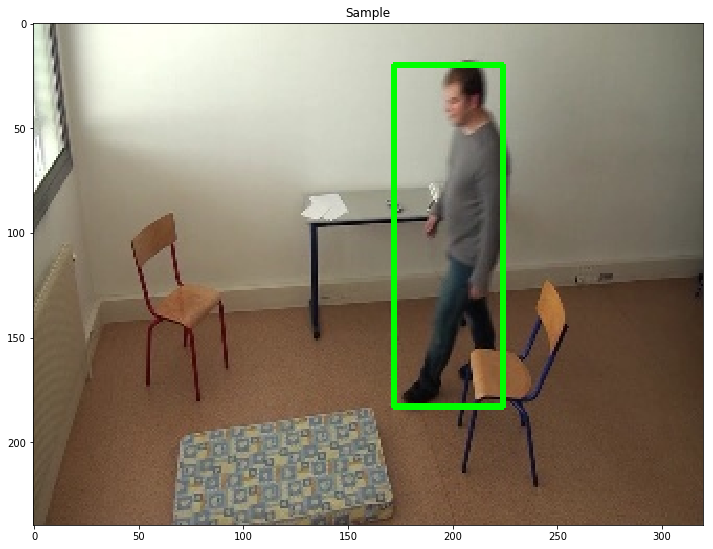

In [25]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(img, title='Sample'):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    figure = plt.figure(figsize = (12,18)) 
    axis = figure.add_subplot(111)
    axis.imshow(rgb_img,interpolation='none')
    axis.set_title(title)
    plt.show()

result = json.load(response['Body'])
persons = [x for x in result if x.get('id', None) == 'person']

if persons:
    person = persons[0]
    
img = cv2.imread(img_jpg['path'])
img = cv2.rectangle(img, (person['left'], person['top']), 
                    (person['right'], person['bottom']), 
                    (0, 255, 0), 2)

show_image(img)

# Create Fall Detector Endpoint

**IMPORTANT:** Before running cell below, copy `model.tar.gz` in folder `model` to S3 bucket and define it as `model_data`

In [26]:
model_data = 's3://sagemaker-us-west-2-*********/model.tar.gz'

'sagemaker-us-west-2-016395583399'

In [28]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

endpoint_name = 'fall-detector'

class FallPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(FallPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='image/png')

model = PyTorchModel(model_data=model_data,
                     role = role,
                     framework_version='1.4.0',
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=FallPredictor)

predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', endpoint_name=endpoint_name)

-------------!

## Test Fall Detection

In [29]:
mhi_png = {'path':'./img/Home_29_164.png'}

with open(mhi_png['path'], "rb") as image:
    mhi_png['byte_array'] = bytearray(image.read())

In [30]:
payload = mhi_png['byte_array']

endpoint_name = 'fall-detector'
content_type = 'image/png'

result = client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType=content_type,
            Body=payload)

In [31]:
json.load(result['Body'])

{'prob': 0.8605935573577881, 'label': 'fall'}

## Test Not-Fall Detection

In [32]:
mhi_png = {'path':'./img/Home_39_142.png'}

with open(mhi_png['path'], "rb") as image:
    mhi_png['byte_array'] = bytearray(image.read())

In [33]:
payload = mhi_png['byte_array']

result = client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType=content_type,
            Body=payload)

json.load(result['Body'])

{'prob': 0.9999940395355225, 'label': 'not_fall'}

# Run an Inference on VDO and Get Summary Results 

In [36]:
import os
import numpy as np
import json
import cv2

class MHIProcessor:
    '''
    Process MHI as inputs of Fall Detector mosel
    '''
    def __init__(self, dim=128):
        # initialize MHI params
        self.index = 0
        self.dim = dim
        self.threshold = 0.1
        self.interval = 2
        self.duration = 40
        self.decay = 1 / self.duration
        
        #initialize frames
        self.mhi_zeros = np.zeros((dim, dim))        
        
    
    def update(self, gray):
        self.index += 1
        if self.index == 1:
            self.prev_frame = cv2.resize(gray,(self.dim, self.dim),
                                         interpolation=cv2.INTER_AREA)
            self.prev_mhi = self.mhi_zeros
            
        if self.index % self.interval == 0:
            frame = cv2.resize(gray,(self.dim, self.dim),
                                         interpolation=cv2.INTER_AREA)
            diff = cv2.absdiff(self.prev_frame, frame)
            binary = (diff >= (self.threshold * 255)).astype(np.uint8)
            mhi = binary + (binary == 0) * np.maximum(self.mhi_zeros,
                                                      (self.prev_mhi - self.decay))
            # update frames
            self.prev_frame = frame
            self.prev_mhi = mhi
            
            if self.index >= self.duration * self.interval:
                img = cv2.normalize(mhi, None, 0.0, 255.0, cv2.NORM_MINMAX)
                flag, encode_img = cv2.imencode('.png', img)
                if flag:
                    return bytearray(encode_img)
                
        return None  

In [37]:
def invoke_predict(client, endpoint_name, content_type, payload):
    response = client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType=content_type,
            Body=payload)
    result = json.load(response['Body'])
    
    return result

In [41]:
### VDO for inference testing provide in vdo folder

# vdo_path = 'vdo/office2_23.avi'
vdo_path = 'vdo/coffee_room_52.avi'

result_path = os.path.basename(vdo_path).replace('.avi', '.json')
result_path = f'result/{result_path}'

cap = cv2.VideoCapture(vdo_path)

print(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print(result_path)

215
result/coffee_room_52.json


In [42]:
%%time

mhi_process = MHIProcessor()

results = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret : break
        
    # MHI processing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mhi = mhi_process.update(gray)
    
    # Person detection
    flag, encoded_image = cv2.imencode('.jpg', frame)
    payload = bytearray(encoded_image)
    endpoint_name = 'gluoncv-object-detector'
    content_type = 'image/jpeg'

    object_detect = invoke_predict(client, endpoint_name, content_type, payload)
    
    persons = [obj for obj in object_detect if obj.get('id', None) == 'person']
    
    if persons:
        result = persons[0]
        # Replace id with frame number
        result['id'] = mhi_process.index
        # Defaults position as not available with prob 0.0
        result['prob'] = 0.0
        result['pos'] = 'na'
        
        if mhi:
            # Fall detection if mhi not None
            payload = mhi
            endpoint_name = 'fall-detector'
            content_type = 'image/png'
            
            fall_detect = invoke_predict(client, endpoint_name, content_type, payload)
            result['prob'] = fall_detect['prob']
            result['pos'] = fall_detect['label']
            
        results.append(result)
        
# Save the summary results in to json file.
with open(result_path, 'w') as f:
    json.dump(results, f)

# When everything done, release the capture
cap.release()

CPU times: user 1.55 s, sys: 33.6 ms, total: 1.59 s
Wall time: 5min 30s


In [47]:
# what the summary result look like
results[200]

{'right': 204,
 'bottom': 189,
 'top': 136,
 'score': 0.9529120326042175,
 'id': 201,
 'left': 81,
 'prob': 0.0,
 'pos': 'na'}

## Visualize Results

Please download `demo.py`, vdo and its correspondant json file into your local computer and run
```python
python demo.py --fname coffee_room_52
```

# Delete Endpoints

**IMPORTANT:** Don't forget to delete both endpoints we created. Check your Sagemaker Endpoints console.